To create our neural network, at first we started with a "custom" implementation. We took inspiration from VGG, and we stacked several
convolutional, activation pooling layers. At the end, before the softmax, we used dense layers with dropout to force neurons to learn
indipendent features. To perform early stopping, we split the dataset in two parts, and we found that 20% for validation was the best
compromise. We also did some tuning regarding data augmentation (the best parameters are the ones found below) and also for the learning
rate; we used a custom callback to change the learning rate at each epoch, as we discovered that this allowed us to better avoid local 
minima. After a few trainings (around 100 epochs), we "hit a wall" with our custom model around 0.65 accuracy in validation, and we decided 
to try transfer learning (see next notebook).

In [ ]:
# This cell is for Colab
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir an2dl_1
%cd an2dl_1
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c artificial-neural-networks-and-deep-learning-2020
!unzip artificial-neural-networks-and-deep-learning-2020.zip
from google.colab import drive
drive.mount('/content/drive')

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import json

SEED = 1234
tf.random.set_seed(SEED)  
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=5,
                                        height_shift_range=5,
                                        #zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='constant',
                                        cval=0.1,
                                        rescale=1./255,
                                        validation_split=0.2)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255)

# Create validation and test ImageDataGenerator objects
valid_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)   # Don't augment validation split
test_data_gen = ImageDataGenerator(rescale=1./255)

In [4]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = './MaskDataset'

# Batch size
bs = 32
EPOCHS = 150

# img shape
img_h = 256
img_w = 256
num_classes=3

with open(os.path.join(dataset_dir,"train_gt.json")) as f:
  dic = json.load(f)
dataframe = pd.DataFrame(dic.items())
dataframe.rename(columns = {0:'filename', 1:'class'}, inplace = True)
dataframe["class"] = dataframe["class"].astype(str)
dataframe = dataframe.sample(frac=1).reset_index(drop=True)


# Training
training_dir = os.path.join(dataset_dir, 'training')
train_gen = train_data_gen.flow_from_dataframe(dataframe,
                                               training_dir,
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED,
                                               subset='training')  # targets are directly converted into one-hot vectors


# Validation
validation_dir = os.path.join(dataset_dir, 'validation')
valid_gen = valid_data_gen.flow_from_dataframe(dataframe,
                                               training_dir,
                                               batch_size=bs, 
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=SEED,
                                               subset='validation')


Found 4492 validated image filenames belonging to 3 classes.
Found 1122 validated image filenames belonging to 3 classes.


In [5]:
# Check how keras assigned the labels
train_gen.class_indices

{'0': 0, '1': 1, '2': 2}

In [6]:
# Create Dataset objects
# ----------------------

# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Shuffle (Already done in generator..)
# train_dataset = train_dataset.shuffle(buffer_size=len(train_gen))

# Normalize images (Already done in generator..)
# def normalize_img(x_, y_):
#     return tf.cast(x_, tf.float32) / 255., y_

# train_dataset = train_dataset.map(normalize_img)

# 1-hot encoding <- for categorical cross entropy (Already done in generator..)
# def to_categorical(x_, y_):
#     return x_, tf.one_hot(y_, depth=10)

# train_dataset = train_dataset.map(to_categorical)

# Divide in batches (Already done in generator..)
# train_dataset = train_dataset.batch(bs)

# Repeat
# Without calling the repeat function the dataset 
# will be empty after consuming all the images
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Repeat
valid_dataset = valid_dataset.repeat()


tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


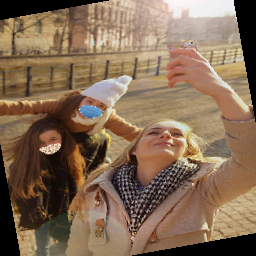

tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


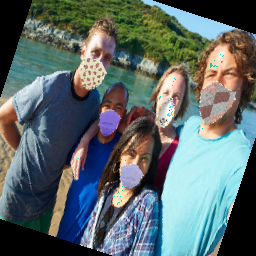

tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


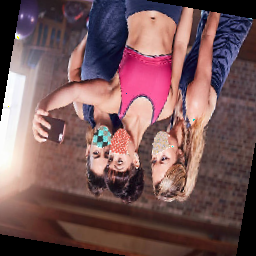

tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


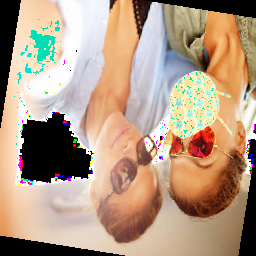

tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


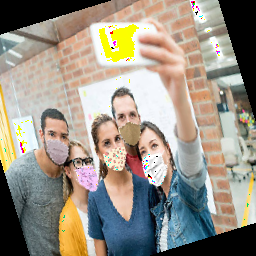

tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


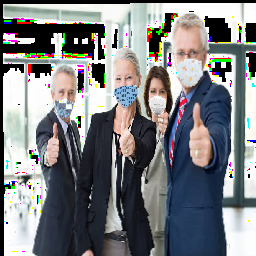

tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


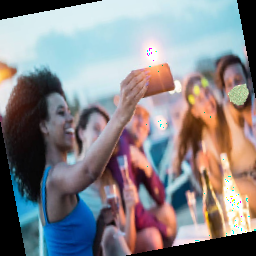

tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


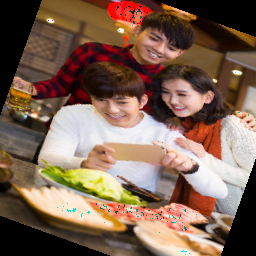

In [7]:
from PIL import Image

train_iter = iter(train_dataset)

# Get training image
for i in range(0, 8):
  train_img, label = next(train_iter)
  print(label[0])
  train_img = train_img[0]
  Image.fromarray(np.uint8(np.array(train_img)*256.))

# Visualize the image


tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


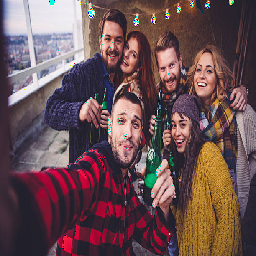

tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


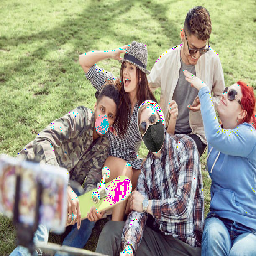

tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


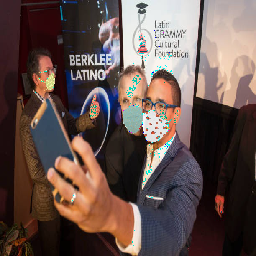

tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


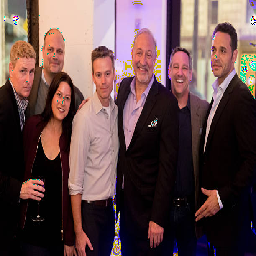

tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


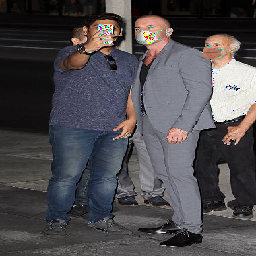

tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


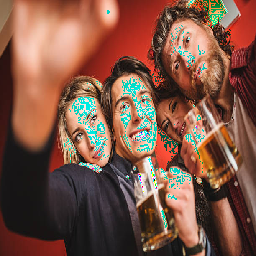

tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


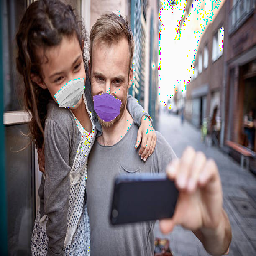

tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


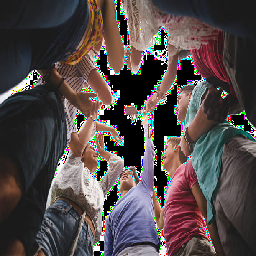

In [8]:
from PIL import Image

valid_iter = iter(valid_dataset)

# Get validation image
for i in range(0, 8):
  valid_img, label = next(valid_iter)
  print(label[0])
  valid_img = valid_img[0]
  Image.fromarray(np.uint8(np.array(valid_img)*256.))

# Visualize the image


In [9]:
# Architecture: Features extraction -> Classifier

start_f = 5
depth = 8

model = tf.keras.Sequential()

# Features extraction

input_shape = [img_h, img_w, 3]



# Conv block: Conv2D -> Activation -> Pooling
model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

input_shape = [None]
model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding='same',
                                 input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

# Classifier
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

In [10]:
# Visualize created model as a table
model.summary()

# Visualize initialized weights
model.weights

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 5)       140       
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 256, 5)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 5)       230       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256, 256, 5)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 5)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 5)       230       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 128, 128, 5)       0

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 5) dtype=float32, numpy=
 array([[[[ 2.19620168e-02, -7.81624466e-02,  4.71291542e-02,
           -1.47900730e-01, -4.02207375e-02],
          [ 2.34514594e-01,  4.16889787e-03, -8.15115720e-02,
            1.60993755e-01,  4.92492020e-02],
          [ 1.55199409e-01, -9.66653228e-03,  5.04544079e-02,
           -2.75569171e-01, -3.71494591e-02]],
 
         [[ 2.76111722e-01,  2.77746141e-01, -2.04104275e-01,
            2.85541773e-01,  1.62444741e-01],
          [-1.61582828e-01, -6.35492802e-03,  7.68591762e-02,
            3.67986560e-02, -5.56182414e-02],
          [-5.84857911e-02,  1.05478406e-01,  1.58268541e-01,
           -3.14537287e-02, -2.55852938e-01]],
 
         [[-1.46674469e-01, -1.12401426e-01, -1.05447084e-01,
           -1.77237332e-01,  1.87729150e-01],
          [ 5.33005297e-02, -7.25178719e-02,  1.98225111e-01,
           -1.49865761e-01,  1.85976803e-01],
          [-1.94861963e-01, -1.34392902e-01, -5.03029227e

Learning rate schedule: 1e-05 to 0.0001 to 1.06e-05


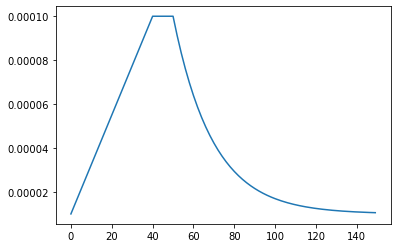

In [11]:
import matplotlib.pyplot as plt
LR_START = 0.00001
LR_MAX = 0.0001 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 40
LR_SUSTAIN_EPOCHS = 10
LR_EXP_DECAY = .95

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [12]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [13]:
#%load_ext tensorboard
#%tensorboard --logdir /content/drive/My\ Drive/Keras3/classification_experiments/

In [14]:
import os
from datetime import datetime


cwd = os.getcwd()

exps_dir = './Classification_experiments'
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'Vggish_v4'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'Ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'Tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)
callbacks.append(lr_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)

In [ ]:
model.fit(x=train_dataset,
          epochs=EPOCHS,  #### set repeat in training dataset
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen), 
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/150
 16/141 [==>...........................] - ETA: 1:24 - loss: 1.0986 - accuracy: 0.3496

In [16]:
# Test
res_dir = os.path.join(exp_dir, 'Results')
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
def create_csv(results, results_dir=res_dir):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')


test_dir = os.path.join(dataset_dir, 'test')

images = [f for f in os.listdir(test_dir)]
images = pd.DataFrame(images)
images.rename(columns = {0:'filename'}, inplace = True)
images["class"] = 'test'

test_gen = train_data_gen.flow_from_dataframe(images,
                                              test_dir,
                                              batch_size=bs,
                                              target_size=(img_h, img_w),
                                              class_mode='categorical',
                                              shuffle=False,
                                              seed=SEED)


test_gen.reset()

predictions = model.predict_generator(test_gen, len(test_gen), verbose=1)

results = {}
images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1

create_csv(results)

Found 450 validated image filenames belonging to 1 classes.
15/15 [==============================] - 6s 401ms/step
